In [35]:
suppressMessages(library(gsheet))
suppressMessages(library(EnvStats))
suppressMessages(library(ggplot2))
suppressMessages(library(data.table))
suppressMessages(library(tidyverse))
suppressMessages(library(stringr))

In [36]:
setwd("/workdir/omm35/paper_urine_cfrna/")
source("/workdir/omm35/paper_urine_cfrna/scripts/theme_ggplot_cfrna.R")

In [47]:
rm(list=ls())

In [48]:
files = list.files(path = ".", recursive = TRUE, pattern="*mapping_stats.tsv", full.names = TRUE)

In [49]:
# files

In [50]:
calculate_qc_metric <- function(files){
    biofluid <- str_extract(files, "/(.*?)/")
    df = fread(files)
    df = df %>% 
    mutate(biofluid = ifelse(str_detect(sample_id, "IRB|VLNT"),"IRB",biofluid))
    
    #df$biofluid<-biofluid
    df$biofluid<-gsub("/",'',df$biofluid)
    df$ribosomal_percentage=100*df$rRNA_reads/df$align_input
    df = df %>% filter(!(ftcount < 75000 | intron_exon_ratio > 3 | ribosomal_percentage > 10))
    df$bias53 = as.numeric(df$bias53)
    df = df %>% mutate(mean_bias= mean(bias53), sd_bias=sd(bias53))
    df = df %>% mutate( Z_score_bias53 = ((bias53 - mean_bias)/sd_bias))
    df = df  %>% filter(abs(Z_score_bias53) < 3)
    
    
    return(df)
}

In [51]:
stats_df=do.call(rbind,lapply(files,calculate_qc_metric))

In [52]:
colnames(stats_df)
unique(stats_df$biofluid)
head((stats_df %>% filter(biofluid=="gvhd_plasma")))

[1] "sample_id"              "reads_all"              "reads_trimmed_filtered"
 [4] "align_input"            "align_unique"           "align_multi"           
 [7] "align_tooshort"         "duplication_rate"       "ftcount"               
[10] "bias53"                 "intron_exon_ratio"      "exon_ratio"            
[13] "exonic_reads"           "intronic_reads"         "intergenic_reads"      
[16] "rRNA_reads"             "mtRNA_reads"            "nuclear_reads"         
[19] "biofluid"               "ribosomal_percentage"   "mean_bias"             
[22] "sd_bias"                "Z_score_bias53"

[1] "aki_plasma"     "aki_urine"      "gvhd_plasma"    "IRB"           
[5] "gvhd_urine"     "healthy_plasma" "healthy_urine"  "ktx_urine"

sample_id,reads_all,reads_trimmed_filtered,align_input,align_unique,align_multi,align_tooshort,duplication_rate,ftcount,bias53,⋯,intronic_reads,intergenic_reads,rRNA_reads,mtRNA_reads,nuclear_reads,biofluid,ribosomal_percentage,mean_bias,sd_bias,Z_score_bias53
<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,<dbl>,⋯,<dbl>,<dbl>,<int>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
gvhd_hct_cfrna_51,12151453,12026879,11505199,1464845,2476086,7456227,0.4416073,494537,1.13,⋯,312986.0,618890.5,230299,40757,1452473,gvhd_plasma,2.001695,1.175397,0.08964912,-0.5063834
gvhd_hct_cfrna_60,16912759,16765635,16228108,2591316,5244427,7949673,0.5285286,669448,1.24,⋯,723714.5,1520205.5,494565,118493,2222666,gvhd_plasma,3.047583,1.175397,0.08964912,0.7206225
gvhd_hct_cfrna_52,10863761,10643569,9725361,2191238,2908648,4405241,0.4713198,602166,1.21,⋯,375174.0,766641.5,318795,111612,1527097,gvhd_plasma,3.277976,1.175397,0.08964912,0.3859845
gvhd_hct_cfrna_53,9595692,9492124,9045516,2096923,3195858,3624773,0.5018436,596620,1.29,⋯,383251.5,679035.5,262498,54616,1780769,gvhd_plasma,2.901968,1.175397,0.08964912,1.2783525
gvhd_hct_cfrna_1,8764496,8757563,8740938,3823362,1546559,3270789,0.2779533,1901043,1.15,⋯,551203.0,643530.0,320269,366311,2739217,gvhd_plasma,3.664012,1.175397,0.08964912,-0.2832914
gvhd_hct_cfrna_2,8363566,8351441,8319975,1737300,2982542,3518729,0.4817920,709353,1.26,⋯,275519.0,576761.0,233309,119994,1781418,gvhd_plasma,2.804203,1.175397,0.08964912,0.9437145


In [53]:
# #urine samples to pool 
# table(stats_df$biofluid)
# urine_gvhd_passed_QC = stats_df  %>% filter(biofluid=="gvhd_urine") %>% select(sample_id,biofluid)
# sample_key = fread("/workdir/omm35/urine_plasma_cfRNA_comparison/metadata_key/plasma_urine_key.tsv")
# sample_key = sample_key[,2:ncol(sample_key)]
# sample_key = sample_key %>% filter(passQC_urine=="TRUE")
# #sample_key  %>% filter(use_pair=="TRUE")
# (sample_key)
# #(urine_gvhd_passed_QC)
# dim(urine_gvhd_passed_QC)
# p = sample_key  %>% filter(sample_id_urine  %in% urine_gvhd_passed_QC$sample_id)
# write_csv(p,"/workdir/omm35/paper_urine_cfrna/pool_samples/gvhd_urine_samples_passed_QC.csv")
#ktx_samples_to_pool
# urine_gvhd_passed_QC = stats_df  %>% filter(biofluid=="ktx_urine") %>% select(sample_id,biofluid)
# write_csv(urine_gvhd_passed_QC,"/workdir/omm35/paper_urine_cfrna/pool_samples/KTX_urine_samples_passed_QC.csv")
# healthy_urine = stats_df  %>% filter(biofluid=="healthy_urine" & !grepl("B",stats_df$sample_id)) %>% select(sample_id,biofluid)
# write_csv(healthy_urine,"/workdir/omm35/paper_urine_cfrna/pool_samples/healthy_urine_samples_passed_QC.csv")
# healthy_urine
# healthy_plasma = stats_df  %>% filter(biofluid=="healthy_plasma" & !grepl("B",stats_df$sample_id)) %>% select(sample_id,biofluid)
# write_csv(healthy_urine,"/workdir/omm35/paper_urine_cfrna/pool_samples/healthy_plasma_samples_passed_QC.csv")
# healthy_plasma

In [54]:
#stats_df$sample_id=gsub("-trimmed","",stats_df$sample_id)

 filter and keep samples that are only to be included in this study

In [55]:
#gvhd_samples
sample_key = fread("/workdir/omm35/urine_plasma_cfRNA_comparison/metadata_key/plasma_urine_key.tsv")
sample_key = sample_key[,2:ncol(sample_key)]
sample_key = sample_key %>% filter(use_pair==TRUE)
sample_key = sample_key  %>% filter((event_sym!="D1" & event_sym!="D2" & event_sym!="R2"))

gvhd_plasma = stats_df[stats_df$sample_id %in% sample_key$sample_id_plasma,]
sample_key = sample_key %>% filter(sample_key$sample_id_plasma  %in% gvhd_plasma$sample_id)
gvhd_urine = stats_df[stats_df$sample_id %in% sample_key$sample_id_urine,]
gvhd_samples=rbind(gvhd_urine,gvhd_plasma)
#sample_key

In [59]:
table(sample_key$event_sym)
dim(gvhd_urine)
dim(gvhd_plasma)


1M 2M 3M 6M D0  E PR 
13 15 15 13 13 15 13 

[1] 97 23

[1] 97 23

In [60]:
#stats_df$sample_id


In [61]:
#For AKI samples
sample_key = fread("/workdir/omm35/urine_plasma_cfRNA_comparison/metadata_key/aki_metadata.csv")
sample_key$plasma_sample_id=paste0(sample_key$plasma_sample_id,"-trimmed")
aki_urine = stats_df[stats_df$sample_id %in% sample_key$urine_sample_id,]
aki_plasma = stats_df[stats_df$sample_id %in% sample_key$plasma_sample_id,]
aki_samples = rbind(aki_urine,aki_plasma)

In [62]:
aki_plasma$sample_id
aki_urine$sample_id
sample_key  %>% filter(!(plasma_sample_id  %in% aki_plasma$sample_id)) 

[1] "aki_cfrna_100-trimmed" "aki_cfrna_101-trimmed" "aki_cfrna_102-trimmed"
 [4] "aki_cfrna_103-trimmed" "aki_cfrna_104-trimmed" "aki_cfrna_106-trimmed"
 [7] "aki_cfrna_33-trimmed"  "aki_cfrna_37-trimmed"  "aki_cfrna_39-trimmed" 
[10] "aki_cfrna_52-trimmed"  "aki_cfrna_56-trimmed"  "aki_cfrna_57-trimmed" 
[13] "aki_cfrna_58-trimmed"  "aki_cfrna_59-trimmed"  "aki_cfrna_61-trimmed" 
[16] "aki_cfrna_63-trimmed"  "aki_cfrna_65-trimmed"  "aki_cfrna_67-trimmed" 
[19] "aki_cfrna_68-trimmed"  "aki_cfrna_72-trimmed"  "aki_cfrna_74-trimmed" 
[22] "aki_cfrna_75-trimmed"  "aki_cfrna_76-trimmed"  "aki_cfrna_77-trimmed" 
[25] "aki_cfrna_78-trimmed"  "aki_cfrna_79-trimmed"  "aki_cfrna_80-trimmed" 
[28] "aki_cfrna_81-trimmed"  "aki_cfrna_86-trimmed"  "aki_cfrna_90-trimmed" 
[31] "aki_cfrna_91-trimmed"  "aki_cfrna_92-trimmed"  "aki_cfrna_97-trimmed" 
[34] "aki_cfrna_99-trimmed"

[1] "aki_cfrna_1_61bp"  "aki_cfrna_10_61bp" "aki_cfrna_11_61bp"
 [4] "aki_cfrna_13_61bp" "aki_cfrna_14_61bp" "aki_cfrna_15_61bp"
 [7] "aki_cfrna_17_61bp" "aki_cfrna_19_61bp" "aki_cfrna_24_61bp"
[10] "aki_cfrna_26_61bp" "aki_cfrna_3_61bp"  "aki_cfrna_31_61bp"
[13] "aki_cfrna_33_61bp" "aki_cfrna_35_61bp" "aki_cfrna_39_61bp"
[16] "aki_cfrna_40_61bp" "aki_cfrna_42_61bp" "aki_cfrna_44_61bp"
[19] "aki_cfrna_6_61bp"  "aki_cfrna_16_61bp" "aki_cfrna_18_61bp"
[22] "aki_cfrna_2_61bp"  "aki_cfrna_21_61bp" "aki_cfrna_23_61bp"
[25] "aki_cfrna_25_61bp" "aki_cfrna_27_61bp" "aki_cfrna_29_61bp"
[28] "aki_cfrna_30_61bp" "aki_cfrna_36_61bp" "aki_cfrna_4_61bp" 
[31] "aki_cfrna_41_61bp" "aki_cfrna_43_61bp" "aki_cfrna_7_61bp" 
[34] "aki_cfrna_9_61bp"

urine_tube_id,main_sequence_id,urine_sample_id,sample_type,plasma_tube_id,plasma_sample_id,study_id,timepoint,causeAKI_orig,sex,age,aliquot,date_tp1,sCr_tp1,date_tp2,sCr_tp2,causeAKI
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<dbl>,<chr>,<chr>,<chr>


In [63]:
p=stats_df  %>% filter(biofluid=="ktx_urine")
p$intron_exon_ratio

[1] 0.5405322 0.2740394 0.5059367 0.9010894 0.8737489 1.3901671 1.1448519
 [8] 1.1850534 0.4658644 0.3450495 0.4757760 0.2370163 0.4037734 0.3444031
[15] 0.4724884 0.2388594 0.1164206 0.2378701 0.4621488 0.9795055 1.7144316
[22] 1.0645922 0.7918672 0.9652184 0.8080716 1.0441618 0.6045852 0.7243848
[29] 1.0363830 1.0982349 1.1917504 0.6116327 0.2623338 1.1719404 0.7192573
[36] 0.2083929 0.7833403 0.3235587 0.5607319 0.4473530 0.9319534 0.5500521
[43] 0.6384041

In [64]:
stats_df = rbind(stats_df  %>% filter(!(biofluid=="gvhd_plasma" | biofluid=="gvhd_urine" | 
                                        biofluid=="aki_plasma" | biofluid=="aki_urine" )),gvhd_samples,aki_samples)

In [65]:
#stats_df = stats_df %>% filter(!(biofluid=="IRB") & !(biofluid=="ktx_urine") & !grepl("B", stats_df$sample_id) )
stats_df = stats_df %>% filter(!(biofluid=="IRB") & !grepl("B", stats_df$sample_id) )
stats_df = stats_df %>% filter(sample_id!="irb-p-cfrna-9-A")

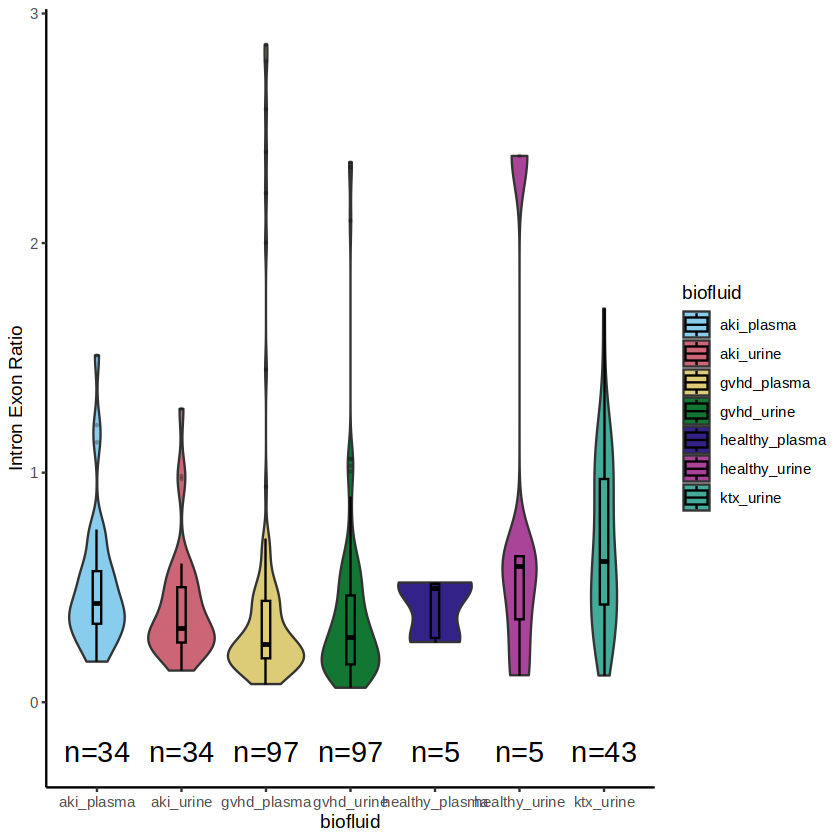

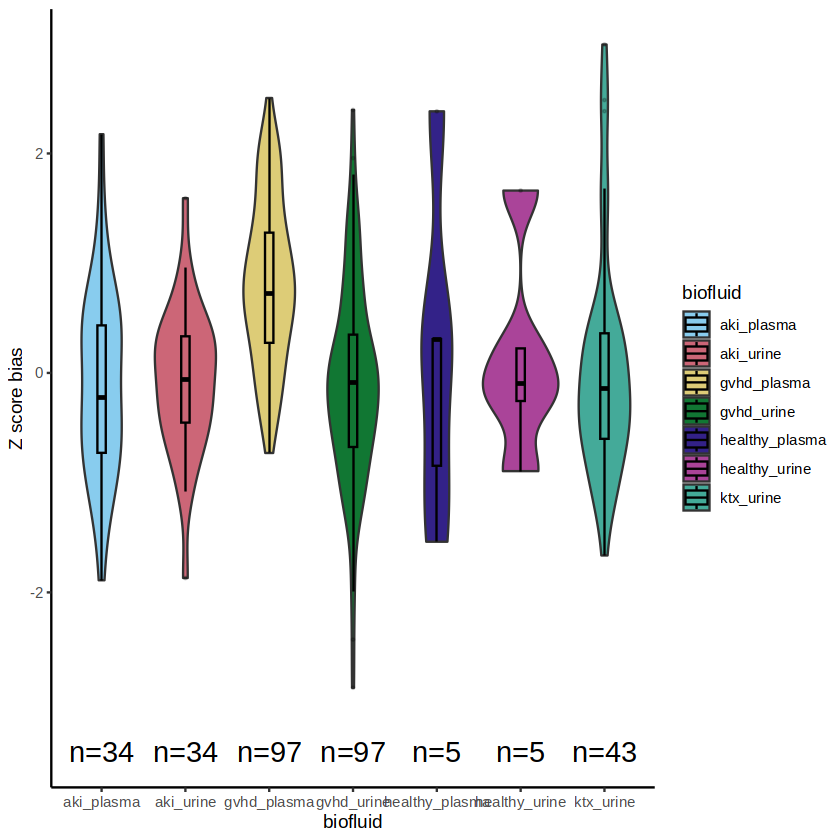

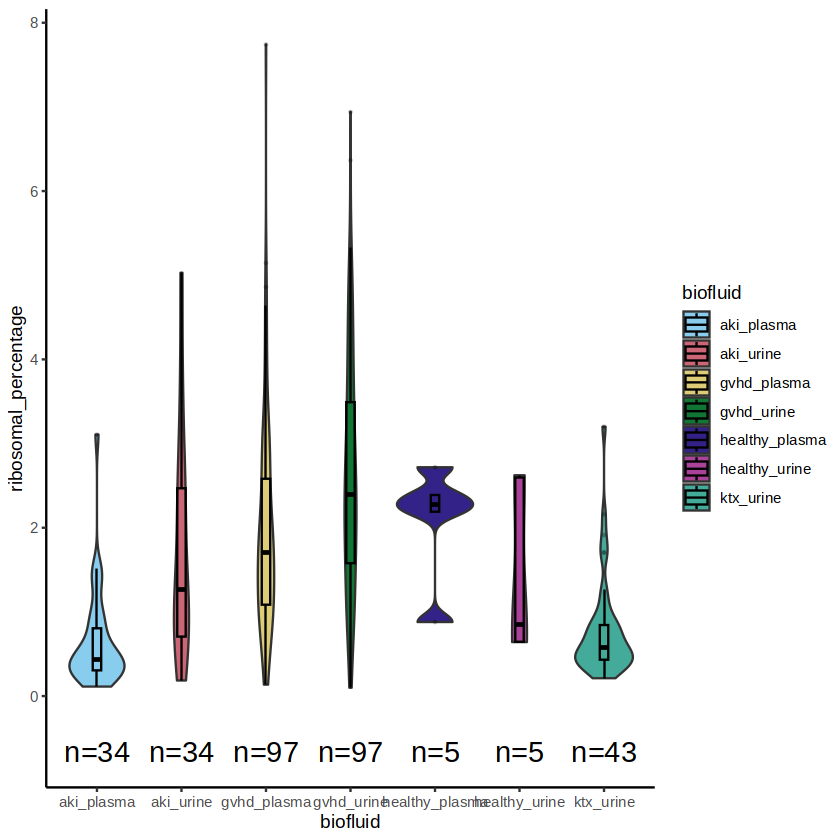

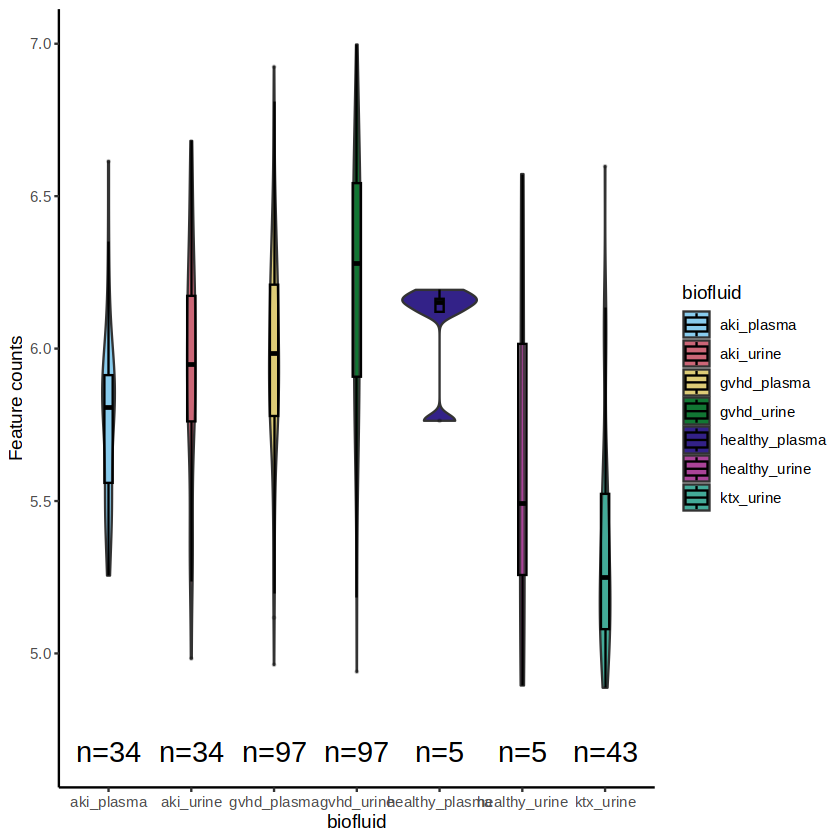

In [66]:
safe_colorblind_palette <- c("#88CCEE", "#CC6677", "#DDCC77", "#117733", "#332288", "#AA4499", 
                         "#44AA99", "#999933", "#882255", "#661100", "#6699CC", "#888888")


stats_df %>% ggplot(.,aes(biofluid, intron_exon_ratio, fill=biofluid))+
geom_violin(width=0.9)+geom_boxplot(width=0.1, color="black", alpha=0.2, outlier.size = 0.3)+
scale_fill_manual(values=safe_colorblind_palette)+
theme_classic()+ylab("Intron Exon Ratio") + stat_n_text(size=6)
#ggsave("figures/figure_1/QC_intron_exon_ratio.pdf", height = 6, width = 7, units = "cm")


stats_df   %>% ggplot(.,aes(biofluid, Z_score_bias53, fill=biofluid))+
geom_violin(width=0.9)+geom_boxplot(width=0.1, color="black", alpha=0.2, outlier.size = 0.3)+
scale_fill_manual(values=safe_colorblind_palette)+ theme_classic()+
  ylab("Z score bias")+ stat_n_text(size=6)
#ggsave("figures/figure_1/QC_z_score_bias.pdf", height = 6, width = 7, units = "cm")


stats_df %>% ggplot(.,aes(biofluid, ribosomal_percentage, fill=biofluid))+
geom_violin(width=0.9)+geom_boxplot(width=0.1, color="black", alpha=0.2, outlier.size = 0.3)+
scale_fill_manual(values=safe_colorblind_palette)+
theme_classic()+ stat_n_text(size=6)
#ggsave("figures/figure_1/QC_ribosomal_percentage.pdf", height = 6, width = 7, units = "cm")

stats_df %>% ggplot(.,aes(biofluid, log10(ftcount), fill=biofluid))+geom_violin(width=0.9)+
geom_boxplot(width=0.1, color="black", alpha=0.2, outlier.size = 0.3)+
scale_fill_manual(values=safe_colorblind_palette) + ylab("Feature counts") + theme_classic()+ stat_n_text(size=6)
#ggsave("figures/figure_1/QC_feature_count.pdf", height = 6, width = 7, units = "cm")


In [67]:
write_csv(stats_df,"metadata/QC_pass_samples.csv")

In [34]:
colnames(stats_df)

[1] "sample_id"              "reads_all"              "reads_trimmed_filtered"
 [4] "align_input"            "align_unique"           "align_multi"           
 [7] "align_tooshort"         "duplication_rate"       "ftcount"               
[10] "bias53"                 "intron_exon_ratio"      "exon_ratio"            
[13] "exonic_reads"           "intronic_reads"         "intergenic_reads"      
[16] "rRNA_reads"             "mtRNA_reads"            "nuclear_reads"         
[19] "biofluid"               "ribosomal_percentage"   "mean_bias"             
[22] "sd_bias"                "Z_score_bias53"